In [82]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc

from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample
from optic.comm.metrics import signal_power
from optic.plot import eyediagram
plt.rcParams["figure.figsize"] = (12,6)


# funcoes
```text
[:SOURce[<n>]]:FUNCtion:SEQuence:LIST:CLEar (Limpa a memoria de waveforms) pg 110
[:SOURce[<n>]][:TRACe]:DATA:DAC16 (Manda uma sequencia de pontos arbitraria para o DAC) pg 155
```

16384

16384



39

In [118]:
def Onda_Dac(DAC,Porta,fs,V_High,V_Low,pontos,filtro):
    pontos = np.array2string(pontos, separator=', ').translate({ord(i): None for i in '[]'}).replace('\n','')

    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:CLEar')
    DAC.write(f':SOURce{Porta}:TRACe:DATA:DAC16 CODE,END, {pontos}')    
    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:SRATe {fs}')
    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:FILTer {filtro}')
    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:LIST:APPLy')
    DAC.write(f':SOURce{Porta}:FUNCtion:SEQuence:STATe ON')
    DAC.write(f':SOURce{Porta}:VOLTage:HIGH {V_High}')
    DAC.write(f':SOURce{Porta}:VOLTage:LOW {V_Low}')

DAC = wfgen
Porta = 2
fs = 10000
V_High = 4
V_Low = 0 
pontos = np.linspace(-32000,32000,64,dtype = int)
filtro = 'NORMal'

Onda_Dac(DAC,Porta,fs,V_High,V_Low,pontos,filtro)

In [115]:
wfgen.write(':SOURce2:FUNCtion:SEQuence:LIST:CLEar')
wfgen.write(':SOURce2:TRACe:DATA:DAC16 CODE,END,10,10,32000,30,40,32000,60,70,80,32000,100,200,300,400,500,32000,32000,32000,32000,32000,32000,32000,32000,32000,32000,32000,32000,32000,32000,32000,32000,32000,32000')
wfgen.write(':SOURce2:FUNCtion:SEQuence:LIST:SRATe 100000')
wfgen.write(':SOURce2:FUNCtion:SEQuence:LIST:APPLy')
wfgen.write(':SOURce2:FUNCtion:SEQuence:STATe ON')

16384

231



37

In [63]:
string = 'Nao tinha medo o tal Joao de Santo Cristo Era o que todos diziam quando ele se perdeu Deixou pra tras todo o marasmo da fazenda So pra sentir no seu sangue o odio que Jesus lhe deu Quando crianca so pensava em ser bandido Ainda mais quando com um tiro de soldado o pai morreu Era o terror da sertania onde morava E na escola ate o professor com ele aprendeu Ia pra igreja so pra roubar o dinheiro Que as velhinhas colocavam na caixinha do altar Sentia mesmo que era mesmo diferente Sentia que aquilo ali nao era o seu lugar Ele queria sair para ver o mar E as coisas que ele via na televisao Juntou dinheiro para poder viajar De escolha propria escolheu a solidao'

for i in range(17):
    if (i+1)*40 < 665:
        wfgen.write(f':DISPlay:TEXT "{(string)[i*40:(i+1)*40]}"')
        time.sleep(2)
    else:
        wfgen.write(f':DISPlay:TEXT "{(string)[i*40:]}"')
        time.sleep(2)  
wfgen.write(f':DISPlay:TEXT:CLEAR')

663


In [6]:
def Gerar_Simbolos(M,nsimbolos,SPS,formatoPulso,nTaps,alpha):
    # Geração de simbolos
    bits = np.random.randint(0,2,int(nsimbolos*np.log2(M)))

    simbolos = modulateGray(bits, M, 'pam')
    simbolos = pnorm(simbolos)

    # Fomartação de pulso
    simbolosup = upsample(simbolos, SPS)
    pulso = pulseShape(formatoPulso, SPS, nTaps, alpha)
    pulso = pulso/max(abs(pulso))
    sinal = firFilter(pulso, simbolosup)
    sinal = sinal.real
    # if formatoPulso == 'rrc':
    #     np.savez('Dados Gerador De sinal/Python/{}PAM_SPS={}_{}_alpha={}.npz'.format(int(M),int(SPS),formatoPulso,alpha), simbolos=simbolos,sinal=sinal)
    # else:
    #     np.savez('Dados Gerador De sinal/Python/{}PAM_SPS={}_{}.npz'.format(int(M),int(SPS),formatoPulso), simbolos=simbolos,sinal=sinal)

    #npz = np.load('{}PAM_SPS={}_{}_aplha={}.npz'.format(int(M),int(SPS),formatoPulso,alpha))
    #print(npz['simbolos'])

    # Geração do arquivo do DAC
    sinal = sinal - np.min(sinal)
    sinal = sinal/np.max(sinal)*65534
    sinal = sinal - 32767
    sinal = (np.rint(sinal)).astype(int)
    return sinal

def Onda_Dac(DAC,Porta,fs,V_High,V_Low,pontos,Nome_Onda):
    DAC.write('DATA:VOLatile:CLEar')
    pontos = np.array2string(pontos, separator=', ').translate({ord(i): None for i in '[]'}).replace('\n','')
    DAC.write('SOURCE{}:DATA:ARB:DAC {}, {}'.format(Porta,Nome_Onda,pontos))    
    DAC.write('SOURCE{}:FUNC:ARB {}'.format(Porta,Nome_Onda))
    DAC.write('SOURCE{}:FUNC ARB'.format(Porta))
    DAC.write('SOURCE{}:FUNC:ARB:SRAT {}'.format(Porta,fs))
    DAC.write('SOURCE{}:VOLT:HIGH {}'.format(Porta,V_High))
    DAC.write('SOURCE{}:VOLT:LOW {}'.format(Porta,V_Low))
    DAC.write('OUTP{} ON'.format(Porta))
    DAC.write('DISPLAY:FOCUS CH{}'.format(Porta))

In [87]:
import pyvisa
rm = pyvisa.ResourceManager()
print(rm.list_resources())

wfgen = rm.open_resource('USB0::0x1AB1::0x0646::DG9R261500165::0::INSTR')
print('Instrument info:', wfgen.query('*IDN?'))

wfgen.write('*rst') # resets the instrument to default configuration
wfgen.write('*opc?') # waits until previous commands are finished

('USB0::0x0957::0x5707::MY53802202::0::INSTR', 'USB0::0x1AB1::0x0646::DG9R261500165::0::INSTR', 'USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
Instrument info: RIGOL TECHNOLOGIES,DG922 Pro,DG9R261500165,00.01.00.00.21 



7

-10922, -10922,  32767,  10922,  32767, -32767,  32767, -10922,  32767,
  10922,  32767, -10922, -10922, -32767, -32767, -10922, -10922,  32767,
  10922, -10922, -10922, -32767,  10922, -10922, -10922,  32767,  10922,
 -10922, -10922,  32767,  32767,  32767


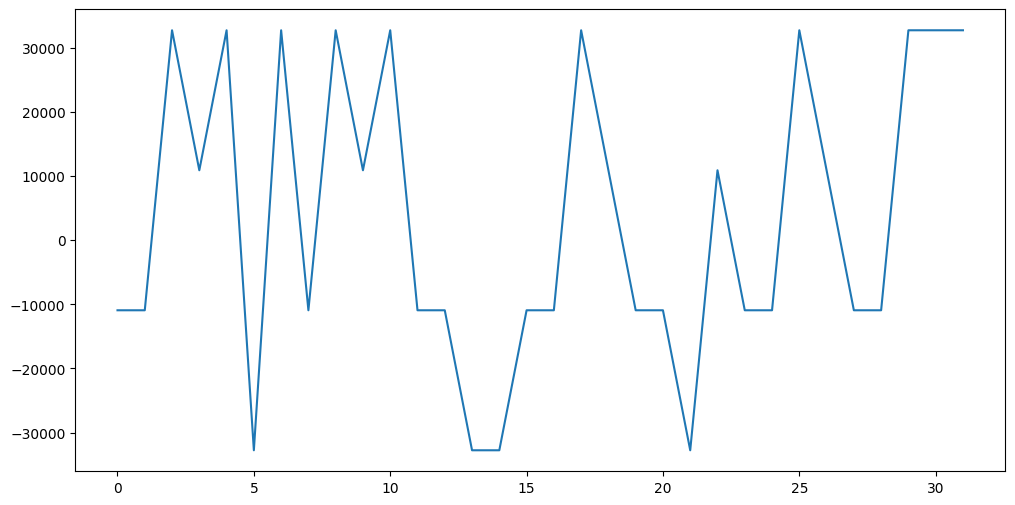

In [414]:
wfgen.write('*rst') 

#Valores Geração do sinal
M = 4 # order of the modulation format
nsimbolos = 32
SPS = 1
formatoPulso = 'rect' #'rect','nrz','rrc'
nTaps = 1024
alpha = 0.1

simbolos = Gerar_Simbolos(M,nsimbolos,SPS,formatoPulso,nTaps,alpha)


plt.plot(simbolos)
print(np.array2string(simbolos, separator=', ').translate({ord(i): None for i in '[]'}))
DAC = wfgen
Porta = 2
fs = 1e5
V_High = 5.0
V_Low = -5
pontos = simbolos
Nome_Onda = 'oi'
Onda_Dac(DAC,Porta,fs,V_High,V_Low,pontos,Nome_Onda)

In [352]:
wfgen.write('*rst') # resets the instrument to default configuration

# Parameters of a square wave

wfgen.write('DATA:VOLatile:CLEar')

#wfgen.write('SOURCE2:DATA:ARB:DAC teste,-10922,  10922,  32767,  32767, -10922, -32767,  10922,  32767,  32767,10922, -32767, -32767, -32767,  32767,  10922, -10922,  10922,  32767,10922, -10922, -32767,  32767,  10922,  32767, -32767,  32767, -32767,-32767, -32767, -10922,  10922, -10922, -32767, -10922,  32767,  32767,10922,  10922, -10922,  10922, -10922, -10922,  32767, -32767,  32767,-10922, -32767,  10922, -32767,  10922, -10922, -10922, -10922, -10922,32767, -10922, -32767, -10922, -32767, -10922, -32767,  32767,  32767,-10922')
wfgen.write('SOURCE2:DATA:ARB:DAC teste, 10922,  10922,  10922, -10922, -10922, -10922, -32767,  32767, -10922,  32767, -10922, -32767,  10922, -10922,  10922, -10922, -10922,  32767,  32767,  32767,  10922, -10922, -32767, -32767, -10922, -32767,  32767,  10922,  10922, -10922,  10922,  32767,  10922,  10922,  10922,  10922,  32767,  32767, -32767, -32767,  32767, -10922,  10922,  10922, -10922, -10922, -32767, -10922, -10922, -32767, -32767,  32767, -10922,  10922, -32767,  32767, -32767,  32767, -32767, -10922,  32767,  32767, -32767,  32767')
#wfgen.write('SOURCE2:DATA:ARB:DAC teste,-32767, 32767,  32767,32767,-32767,32767,-32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767,32767')
wfgen.write('SOURCE2:FUNC:ARB teste')
#print(wfgen.query('DATA:ATTR:AVER? teste'))


wfgen.write('SOURCE2:FUNC ARB')
wfgen.write('SOURCE2:FREQ +1E+05')
wfgen.write('SOURCE2:FUNC:SQU:DCYC +20')
wfgen.write('SOURCE2:VOLT:HIGH +2.0')
wfgen.write('SOURCE2:VOLT:LOW 0')
wfgen.write('OUTP2 ON')

wfgen.write('DISPLAY:FOCUS CH2')

19

In [323]:
wfgen.write('DISPLAY:FOCUS CH2')

19

In [273]:
wfgen.write('DATA:VOLatile:CLEar')

wfgen.write('SOURCE2:DATA:ARB teste,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0')
print(wfgen.query('SYSTem:ERRor?'))
wfgen.write('SOURCE2:FUNC:ARB teste')

print(wfgen.query('SYSTem:ERRor?'))
print(wfgen.query('SOURCE2:FUNC:ARB?'))

+0,"No error"

+0,"No error"

"TESTE"



In [249]:
wfgen.write('SOURCE2:FUNC SIN')
wfgen.write('FUNC:ARB teste')
wfgen.write('SOURCE2:FUNC ARB')

18

In [204]:
wfgen.write('MMEM:LOAD:DATA "EXP_RISE.arb"')
print(wfgen.query('SYSTem:ERRor?'))

-257,"File name error; invalid character in name"



In [200]:
#wfgen.write('DATA:VOLatile:CLEar')
#wfgen.write('DISPLAY:FOCUS CH2')
#wfgen.write('DATA:ARB:DAC teste,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0')
#wfgen.write('FUNC:ARB teste')
#wfgen.write('MMEM:STORE:DATA "INT:\teste.arb"')
wfgen.write('DATA:VOLatile:CLEar')
wfgen.write('MMEM:LOAD:DATA "INT:\teste.arb"')
print(wfgen.query('SYSTem:ERRor?'))
#wfgen.write('FUNC ARB')
#wfgen.write('FUNC:ARB "INT:\teste.arb"')
#print(wfgen.query('SYSTem:ERRor?'))
#wfgen.write('SOURCE2:FUNC ARB ')

-257,"File name error; invalid character in name"



In [182]:
wfgen.write('MMEM:CAT?')    

11

In [206]:
wfgen.write('DISPLAY:TEXT:CLEAR')
#wfgen.write('DISPLAY:TEXT "DAC HACKEADO"')

20

In [119]:
wfgen.close()
rm.close()
